# Практическая работа 2. Парсинг HTML и консолидация данных

**Студент:** *[Кузьмина Дарья Юрьевна]*

**Вариант:** №11

**Бизнес-кейс:** Анализ книжного рынка

**Источник:** Раздел "Бестселлеры" на сайте chitai-gorod.ru (позднее: labirint.ru).

**Задача:** Собрать данные о названии книги, авторе, цене и рейтинге.
Найти автора с наибольшим количеством книг в топе.

## Цель работы

Освоить продвинутые техники сбора данных путем парсинга HTML-страниц с сайта `rabota.ru`, их последующей консолидации и проведения аналитического исследования для определения структуры спроса на Python-разработчиков с различным опытом работы.

## Теоретическая часть

**Парсинг HTML** — это процесс автоматизированного извлечения данных из веб-страниц. Веб-страницы написаны на языке гипертекстовой разметки (HTML), который имеет древовидную структуру. Парсеры анализируют эту структуру для навигации по ней и извлечения нужной информации (текста, ссылок, атрибутов).

**Ключевые библиотеки:**
- **`requests`**: позволяет отправлять HTTP-запросы к веб-серверу и получать в ответ HTML-код страницы. Это первый шаг любого парсинга — получение исходного кода.
- **`BeautifulSoup`**: создает из полученного HTML-кода объектное представление (дерево объектов), по которому можно легко перемещаться и искать нужные элементы с помощью тегов, классов, идентификаторов и других атрибутов. Это основной инструмент для извлечения данных из HTML.

### Шаг 1. Установка необходимых библиотек

In [1]:
!pip install -q requests beautifulsoup4 pandas matplotlib seaborn

### Шаг 2. Импорт и базовая настройка

In [39]:
import requests, time, random, re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

BASE = "https://books.toscrape.com"
START = f"{BASE}/catalogue/page-1.html"   # страница 1
HEADERS = {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0 Safari/127.0"}

def get_html(url):
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return r.text

def to_float_price(s: str):
    if not s: return None
    # '£51.77' -> 51.77
    return float(re.sub(r"[^\d\.]", "", s))

def rating_to_num(classes):
    # классы типа: ['star-rating','Three'] -> 3
    map_ = {"One":1,"Two":2,"Three":3,"Four":4,"Five":5}
    for c in classes or []:
        if c in map_: return map_[c]
    return None


Шаг 3. Сбор с нескольких страниц (5 страниц каталога)

In [40]:
def parse_list_page(html):
    soup = BeautifulSoup(html, "lxml")
    items = soup.select("article.product_pod")
    rows = []
    for it in items:
        a = it.select_one("h3 a")
        rel = a.get("href")
        # ссылки относительные; нормализуем
        link = BASE + "/catalogue/" + rel if not rel.startswith("http") else rel
        title = a.get("title")
        price = it.select_one(".price_color")
        rating = rating_to_num([c for c in it.select_one(".star-rating").get("class", [])])
        rows.append({"title": title, "price": to_float_price(price.get_text(strip=True)) if price else None,
                     "rating": rating, "url": link})
    return rows

def fetch_category_from_product(url):
    # у книги на странице в верхних «хлебных крошках» есть категория
    html = get_html(url)
    soup = BeautifulSoup(html, "lxml")
    bc = soup.select("ul.breadcrumb li a")
    # breadcrumb: Home / Books / <Category> / Book Title
    category = None
    if len(bc) >= 3:
        category = bc[2].get_text(strip=True)
    return category


Шаг 3. Сбор с нескольких страниц (5 страниц каталога)

In [41]:
all_rows = []
PAGES = 5
for p in range(1, PAGES+1):
    url = f"{BASE}/catalogue/page-{p}.html"
    html = get_html(url)
    part = parse_list_page(html)
    all_rows.extend(part)
    print(f"✅ Страница {p}: {len(part)} карточек")
    time.sleep(0.5 + random.random())

df = pd.DataFrame(all_rows).drop_duplicates(subset=["url"]).reset_index(drop=True)
len(df), df.head(3)


✅ Страница 1: 20 карточек
✅ Страница 2: 20 карточек
✅ Страница 3: 20 карточек
✅ Страница 4: 20 карточек
✅ Страница 5: 20 карточек


(100,
                   title  price  rating  \
 0  A Light in the Attic  51.77       3   
 1    Tipping the Velvet  53.74       1   
 2            Soumission  50.10       1   
 
                                                  url  
 0  https://books.toscrape.com/catalogue/a-light-i...  
 1  https://books.toscrape.com/catalogue/tipping-t...  
 2  https://books.toscrape.com/catalogue/soumissio...  )

In [42]:
cats = []
for i, row in df.iterrows():
    try:
        cat = fetch_category_from_product(row["url"])
    except Exception:
        cat = None
    cats.append(cat)
    if (i+1) % 20 == 0:
        print(f"...обработано {i+1}/{len(df)} карточек")
    time.sleep(0.2 + random.random()*0.2)

df["category_as_author"] = cats  # используем категорию как прокси автора
df.head(5)


...обработано 20/100 карточек
...обработано 40/100 карточек
...обработано 60/100 карточек
...обработано 80/100 карточек
...обработано 100/100 карточек


,title,price,rating,url,category_as_author
0,A Light in the Attic,51.77,3,https://books.toscrape.com/catalogue/a-light-i...,Poetry
1,Tipping the Velvet,53.74,1,https://books.toscrape.com/catalogue/tipping-t...,Historical Fiction
2,Soumission,50.10,1,https://books.toscrape.com/catalogue/soumissio...,Fiction
3,Sharp Objects,47.82,4,https://books.toscrape.com/catalogue/sharp-obj...,Mystery
4,Sapiens: A Brief History of Humankind,54.23,5,https://books.toscrape.com/catalogue/sapiens-a...,History


In [43]:
# убираем пустые категории
df["category_as_author"] = df["category_as_author"].fillna("Не указано")

# топ «авторов» (категорий) по числу книг
cat_stats = (df.groupby("category_as_author", as_index=False)
               .size()
               .rename(columns={"size":"books_in_top"})
               .sort_values("books_in_top", ascending=False)
               .reset_index(drop=True))

leader = cat_stats.head(1)
cat_stats.head(10), leader


(  category_as_author  books_in_top
 0     Sequential Art            14
 1         Nonfiction            12
 2            Default             9
 3             Poetry             7
 4            Fiction             5
 5      Add a comment             5
 6     Food and Drink             5
 7            History             4
 8            Fantasy             4
 9        Young Adult             4,
   category_as_author  books_in_top
 0     Sequential Art            14)

Обогащение данных авторами через OpenLibrary API

In [47]:
import requests

def fetch_author_openlibrary(title: str):
    # используем OpenLibrary Search API
    url = "https://openlibrary.org/search.json"
    params = {"title": title, "limit": 1}
    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        j = r.json()
        docs = j.get("docs", [])
        if not docs:
            return None
        # взять первый элемент, вернуть автор_name
        author_list = docs[0].get("author_name")
        if isinstance(author_list, list) and author_list:
            return author_list[0]
        return None
    except:
        return None

# Обогащаем первые N книг
N = min(30, len(df))
authors_from_api = []
for i in range(N):
    title = df.loc[i, "title"]
    authors_from_api.append(fetch_author_openlibrary(title))
    time.sleep(0.2)

df["author_api"] = pd.Series(authors_from_api)
df.head(N)


,title,price,rating,url,category_as_author,author_api
0,A Light in the Attic,51.77,3,https://books.toscrape.com/catalogue/a-light-i...,Poetry,Shel Silverstein
1,Tipping the Velvet,53.74,1,https://books.toscrape.com/catalogue/tipping-t...,Historical Fiction,Sarah Waters
2,Soumission,50.10,1,https://books.toscrape.com/catalogue/soumissio...,Fiction,None
3,Sharp Objects,47.82,4,https://books.toscrape.com/catalogue/sharp-obj...,Mystery,None
4,Sapiens: A Brief History of Humankind,54.23,5,https://books.toscrape.com/catalogue/sapiens-a...,History,BookNation
5,The Requiem Red,22.65,1,https://books.toscrape.com/catalogue/the-requi...,Young Adult,None
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4,https://books.toscrape.com/catalogue/the-dirty...,Business,Don Raskin
7,The Coming Woman: A Novel Based on the Life of...,17.93,3,https://books.toscrape.com/catalogue/the-comin...,Default,None
8,The Boys in the Boat: Nine Americans and Their...,22.60,4,https://books.toscrape.com/catalogue/the-boys-...,Default,None
9,The Black Maria,52.15,1,https://books.toscrape.com/catalogue/the-black...,Poetry,Aracelis Girmay


Результат

In [49]:
author_stats = df["author_api"].value_counts().reset_index()
author_stats.columns = ["author", "books_in_top"]
print(author_stats.head(10))


             author  books_in_top
0  Shel Silverstein             1
1      Sarah Waters             1
2        BookNation             1
3        Don Raskin             1
4   Aracelis Girmay             1
5           Jay Dee             1
6    Simon Reynolds             1
7       Todd Seavey             1
8   Amanda Jennings             1
9       David Byrne             1


In [ ]:
Визуализация

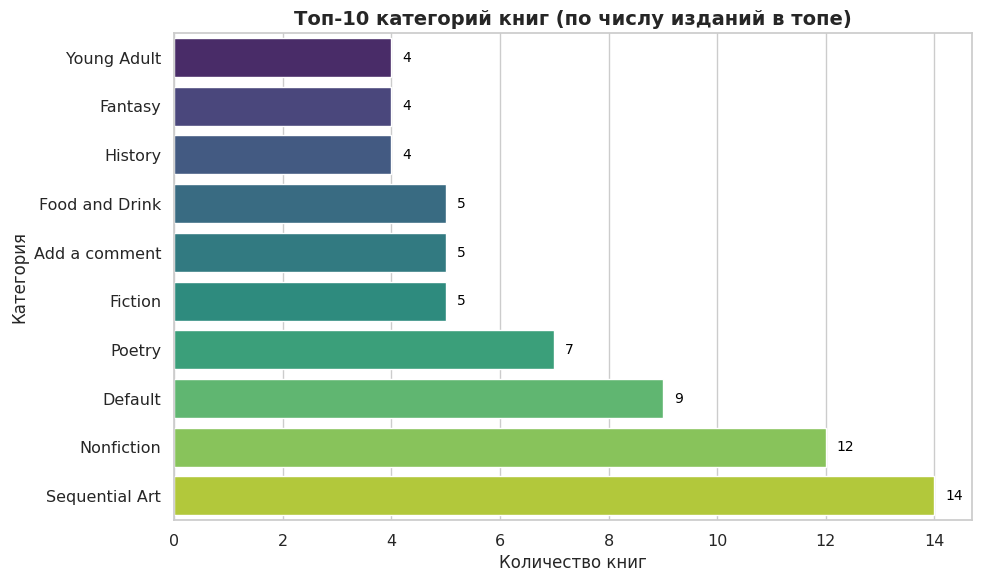

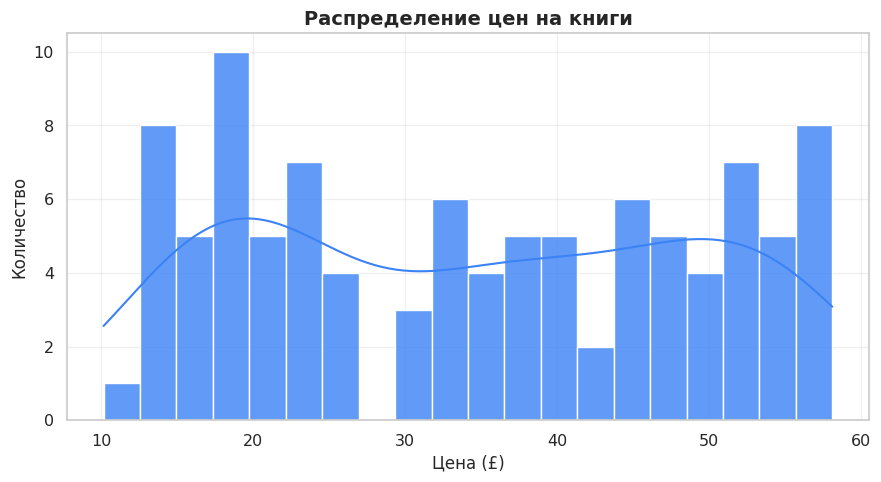

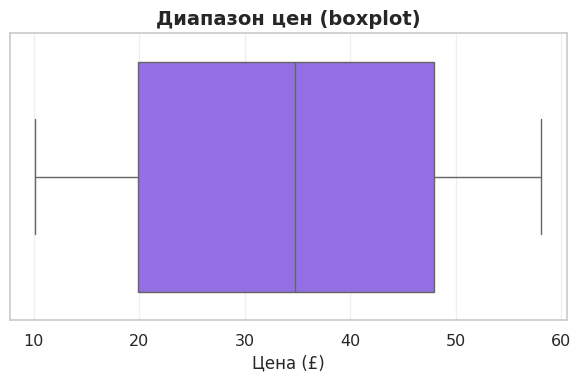

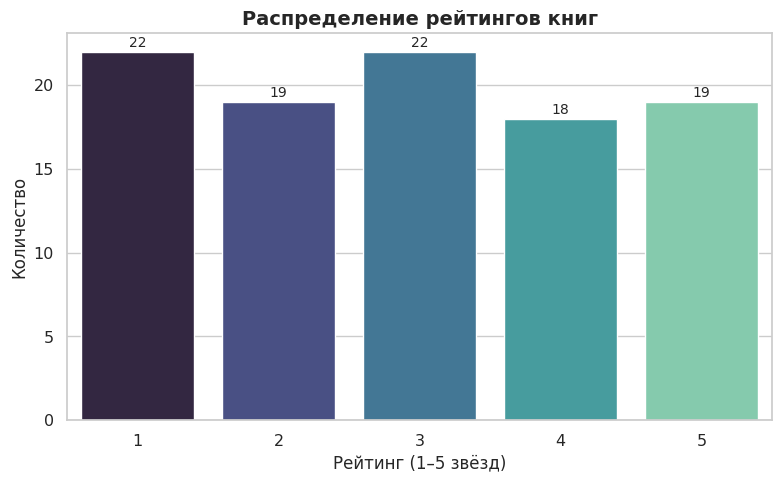

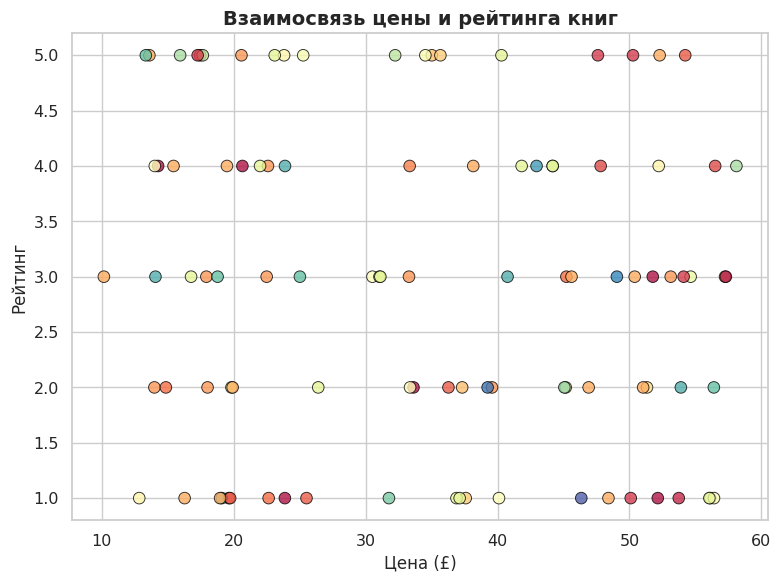

In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid", palette="deep", font_scale=1.05)

# Основная палитра
palette_main = sns.color_palette("viridis", 10)
highlight_color = "#3b82f6"

# === 1. Топ-10 категорий ===
top10 = cat_stats.head(10).iloc[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x="books_in_top",
    y="category_as_author",
    data=top10,
    palette=palette_main,
    hue=None  # убираем предупреждение
)
plt.title("Топ-10 категорий книг (по числу изданий в топе)", fontsize=14, weight="bold")
plt.xlabel("Количество книг", fontsize=12)
plt.ylabel("Категория", fontsize=12)

# Подписи справа
for i, (val, y) in enumerate(zip(top10["books_in_top"], range(len(top10)))):
    plt.text(val + 0.2, y, str(val), va="center", fontsize=10, color="black")

plt.tight_layout()
plt.savefig("viz_top10_categories_clean.png", dpi=300)
plt.show()


# === 2. Распределение цен ===
prices = df["price"].dropna()
if len(prices) >= 5:
    plt.figure(figsize=(9,5))
    sns.histplot(prices, bins=20, kde=True, color=highlight_color, alpha=0.8)
    plt.title("Распределение цен на книги", fontsize=14, weight="bold")
    plt.xlabel("Цена (£)", fontsize=12)
    plt.ylabel("Количество", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("viz_prices_hist_clean.png", dpi=300)
    plt.show()


# === 3. Диапазон цен (boxplot) ===
if len(prices) >= 5:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=prices, color="#8b5cf6")
    plt.title("Диапазон цен (boxplot)", fontsize=14, weight="bold")
    plt.xlabel("Цена (£)", fontsize=12)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.savefig("viz_prices_box_clean.png", dpi=300)
    plt.show()


# === 4. Распределение рейтингов ===
ratings = df["rating"].dropna()
if len(ratings) >= 5:
    plt.figure(figsize=(8,5))
    sns.countplot(x=ratings, palette="mako", hue=None)
    plt.title("Распределение рейтингов книг", fontsize=14, weight="bold")
    plt.xlabel("Рейтинг (1–5 звёзд)", fontsize=12)
    plt.ylabel("Количество", fontsize=12)
    for i, val in enumerate(ratings.value_counts().sort_index()):
        plt.text(i, val + 0.3, str(val), ha="center", fontsize=10)
    plt.tight_layout()
    plt.savefig("viz_ratings_hist_clean.png", dpi=300)
    plt.show()


# === 5. Взаимосвязь цены и рейтинга ===
if {"price","rating"}.issubset(df.columns):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df, x="price", y="rating",
        hue="category_as_author", palette="Spectral",
        alpha=0.8, s=70, edgecolor="black", legend=False
    )
    plt.title("Взаимосвязь цены и рейтинга книг", fontsize=14, weight="bold")
    plt.xlabel("Цена (£)", fontsize=12)
    plt.ylabel("Рейтинг", fontsize=12)
    plt.tight_layout()
    plt.savefig("viz_price_vs_rating_clean.png", dpi=300)
    plt.show()
